In [1]:
# Способы борьбы с мультиколлинеарностью: Ridge, LASSO, PCA

import pandas as pd # работа с таблицами 
import numpy as np # математические функции и матрицы
import matplotlib.pyplot as plt # графики
import seaborn as sns # еще более классные графики
import statsmodels.api as sm # стандартные регрессионные модели
import statsmodels.formula.api as smf # аналогичные модели с синтаксисом в стиле R
import statsmodels.graphics.gofplots as gf # визуализация моделей
from statsmodels.stats.outliers_influence import summary_table # работа с выбросами
from scipy.stats import shapiro # тест Шапиро – Уилка 
from sklearn.decomposition import PCA # функция PCA, вычисляющая главные компоненты
from sklearn.preprocessing import StandardScaler # стандартизация признаков
from sklearn.linear_model import ElasticNetCV, ElasticNet # Ridge, LASSO

In [2]:
get_ipython().system('pip install rdatasets') # наборы данных
# !pip install pyreadstat # чтение spss/stata данных
from rdatasets import data 
# from pyreadstat import read_sav, set_value_labels

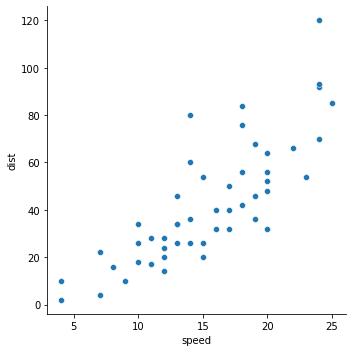

In [3]:
# LASSO
cars = data('cars')
sns.relplot(data=cars, x='speed', y='dist')

In [4]:
# Предположив по графику присутствие нелинейной зависимости между dist и speed, добавим новые переменные
cars['speed2'] = cars['speed'] ** 2
cars['speed3'] = cars['speed'] ** 3

In [5]:
# Стандартизируем объясняющие и зависимую переменные (среднее = 0, стандартное отклонение = 1)
all_scaled = StandardScaler().fit_transform(cars)

# Определим стандартизирвоанную зависимую переменную в вектор y, а объясняющие стандартизирвоанные переменные - в матрицу X
y = all_scaled[:, 1]
X = all_scaled[:, [0, 2, 3]]

# В вектор y_unscaled положим исходную переменную dist
y_unscaled = cars['dist']

In [44]:
# Оценим LASSO при lambda (alpha) = 0.1
from sklearn.linear_model import Lasso

model = Lasso(alpha=0.1, fit_intercept=True, max_iter = 100000).fit(X, y_unscaled)

In [45]:
model.alpha

0.1

In [46]:
# Выведем оценки коэффициентов модели
model.coef_

array([11.02616582,  0.        , 10.0723411 ])

In [47]:
# Оценка константы
model.intercept_

42.98

In [48]:
# Теперь посмотрим как изменятся оценки коэффициентов, перебирая разные lambda (alpha)
alphas = [0.0001, 0.001, 0.01, 0.1, 1]
models = [Lasso(alpha, fit_intercept=True, max_iter = 100000).fit(X, y_unscaled) for alpha in alphas]

In [49]:
betas_hat = [model.coef_ for model in models]
betas_hat

[array([ 35.47502477, -56.15085402,  42.71647696]),
 array([ 34.34686686, -53.55500363,  41.2090767 ]),
 array([ 23.0756748 , -27.62022455,  26.14877112]),
 array([11.02616582,  0.        , 10.0723411 ]),
 array([10.56215652,  0.        ,  9.60801041])]

In [79]:
# А теперь попробуем определить оптимальное значение для lambda (alpha), перебирая ее значения от 0.000001 до 1 с шагом 0.01,
# используя алгоритм кросс-валидации (разобъем нашу выборку на 10 равнхы подвыборок, то есть cv=10)
from sklearn.linear_model import LassoCV
more_alphas = np.arange(0.000001, 1, 0.01)
fit_lr = LassoCV(alphas=more_alphas, cv=10, max_iter=1000000).fit(X, y_unscaled)
print(fit_lr.alpha_)

0.160001


In [80]:
# Оценим LASSO при оптимальном значении lambda(alpha)=0.160001
lasso_best = Lasso(alpha=fit_lr.alpha_, fit_intercept=True).fit(X, y_unscaled)
print(lasso_best.coef_) # выведем оценки коэффициентом модели
print(lasso_best.intercept_) # а также оценку константы в модели

[10.99468671  0.         10.04189658]
42.98


In [81]:
# Построим прогноз по модели для двух новых наблюдений speed = 10 и speed = 20
new = [[4, 16, 64], [10, 100, 1000]]
lasso_best.predict(new)

array([  729.64012768, 10194.82344285])

In [82]:
# Теперь перейдем к Ridge-регрессии
# Оценим ридж-регрессию для lambda(alpha)=0.1
from sklearn.linear_model import Ridge
model_rr = Ridge(alpha=0.1, fit_intercept=True).fit(X, y_unscaled)

In [74]:
model_rr.coef_

array([13.23071552, -4.97955278, 12.99826117])

In [75]:
model_rr.intercept_

42.98

In [83]:
from sklearn.linear_model import RidgeCV
more_alphas = np.arange(0.000001, 1, 0.01)
fit_rr = RidgeCV(alphas=more_alphas, cv=10).fit(X, y_unscaled)
print(fit_rr.alpha_)

0.990001


In [78]:
fit_rr.alpha_

0.990001

In [84]:
fit_rr.coef_

array([8.39242819, 5.51740076, 7.05215417])

In [85]:
fit_rr.intercept_

42.98

In [86]:
# Оценим Ridge при оптимальном значении lambda(alpha)=0.0.990001
ridge_best = Ridge(alpha=fit_rr.alpha_, fit_intercept=True).fit(X, y_unscaled)
print(ridge_best.coef_) # выведем оценки коэффициентом модели
print(ridge_best.intercept_) # а также оценку константы в модели

[8.39242819 5.51740076 7.05215417]
42.98


In [87]:
# Построим прогноз по модели для двух новых наблюдений speed = 10 и speed = 20
new = [[4, 16, 64], [10, 100, 1000]]
ridge_best.predict(new)

array([ 616.16599193, 7730.79852963])

In [ ]:
# Метод главных компонент (Principal Component Analysis)

data = pd.read_excel('/Users/polinapogorelova/Desktop/Метрика_ИП/Данные/dataflats.xlsx')

In [ ]:
data.head()

In [97]:
data['price_sq'] = data['price']/data['totsp']
data

,price,totsp,livesp,kitsp,dist,metrdist,walk,brick,floor,factor,price_sq
0,81,58,40,6.0,12.5,7,1,1,1,кирпич,1.396552
1,75,44,28,6.0,13.5,7,1,0,1,не кирпич,1.704545
2,128,70,42,6.0,14.5,3,1,1,1,кирпич,1.828571
3,95,61,37,6.0,13.5,7,1,0,1,не кирпич,1.557377
4,330,104,60,11.0,10.5,7,0,1,1,кирпич,3.173077
...,...,...,...,...,...,...,...,...,...,...,...
2035,110,77,45,10.0,12.0,5,0,0,1,не кирпич,1.428571
2036,95,60,43,6.0,9.0,5,0,0,1,не кирпич,1.583333
2037,95,60,46,5.0,10.5,5,1,0,1,не кирпич,1.583333
2038,129,76,48,10.0,12.5,5,0,0,1,не кирпич,1.697368


In [98]:
features = ['totsp', 'livesp', 'kitsp', 'dist', 'metrdist'] # добавляем количественные регрессоры в отдельный список
x = data[features] # отбираем признаки
y = data['price_sq'] # выделяем целевую переменную
x_scaled = StandardScaler().fit_transform(x) # стандартизируем регрессоры

In [99]:
y

0       1.396552
1       1.704545
2       1.828571
3       1.557377
4       3.173077
          ...   
2035    1.428571
2036    1.583333
2037    1.583333
2038    1.697368
2039    1.609375
Name: price_sq, Length: 2040, dtype: float64

In [100]:
x_scaled

array([[-0.99765678, -0.80295532, -1.040579  ,  0.4398343 , -0.29286045],
       [-1.92359847, -2.3234029 , -1.040579  ,  0.73615595, -0.29286045],
       [-0.20399248, -0.54954739, -1.040579  ,  1.03247761, -1.34145247],
       ...,
       [-0.8653794 , -0.04273153, -1.39952069, -0.15280901, -0.81715646],
       [ 0.19283968,  0.2106764 ,  0.39518776,  0.4398343 , -0.81715646],
       [-0.60082463, -0.1694355 , -0.68163731,  1.32879926, -0.81715646]])

In [101]:
pca_model = PCA(n_components=5) # создаем 6 главныx компонент
principalComponents = pca_model.fit_transform(x_scaled)
principaldata = pd.DataFrame(data = principalComponents, columns = ['PC1', 'PC2', 'PC3', 'PC4', 'PC5']) # создаем таблицу, в которую сохраняем значения найденных компонент
principaldata

,PC1,PC2,PC3,PC4,PC5
0,-1.664595,-0.170182,-0.382594,-0.235535,-0.019761
1,-3.132676,-0.058395,-0.619063,0.778132,0.055991
2,-1.065828,-0.464760,-1.553843,-0.575355,0.440988
3,-1.802300,0.046424,-0.623437,-0.065274,0.324892
4,2.665792,-0.010419,-0.201316,-0.725857,0.426100
...,...,...,...,...,...
2035,0.275382,-0.316997,-0.834723,0.330752,0.149290
2036,-1.189425,-1.227353,0.013890,-0.328122,-0.077456
2037,-1.229762,-0.987383,-0.245725,-0.906326,-0.177236
2038,0.429200,-0.226317,-0.919538,0.076687,-0.109912


In [102]:
principalComponents

array([[-1.66459452, -0.17018166, -0.38259433, -0.23553509, -0.01976062],
       [-3.13267558, -0.05839455, -0.6190627 ,  0.77813226,  0.05599062],
       [-1.06582774, -0.4647602 , -1.55384348, -0.57535536,  0.4409881 ],
       ...,
       [-1.22976237, -0.98738285, -0.24572519, -0.9063262 , -0.17723567],
       [ 0.42919957, -0.22631679, -0.91953842,  0.07668686, -0.10991179],
       [-0.97219257,  0.12719381, -1.41041236, -0.54458839, -0.20150438]])

In [103]:
principaldata['price_sq'] = y
principaldata['walk'] = data['walk']
principaldata

,PC1,PC2,PC3,PC4,PC5,price_sq,walk
0,-1.664595,-0.170182,-0.382594,-0.235535,-0.019761,1.396552,1
1,-3.132676,-0.058395,-0.619063,0.778132,0.055991,1.704545,1
2,-1.065828,-0.464760,-1.553843,-0.575355,0.440988,1.828571,1
3,-1.802300,0.046424,-0.623437,-0.065274,0.324892,1.557377,1
4,2.665792,-0.010419,-0.201316,-0.725857,0.426100,3.173077,0
...,...,...,...,...,...,...,...
2035,0.275382,-0.316997,-0.834723,0.330752,0.149290,1.428571,0
2036,-1.189425,-1.227353,0.013890,-0.328122,-0.077456,1.583333,0
2037,-1.229762,-0.987383,-0.245725,-0.906326,-0.177236,1.583333,1
2038,0.429200,-0.226317,-0.919538,0.076687,-0.109912,1.697368,0


In [73]:
pca.explained_variance_ratio_

array([0.50402812, 0.21584758, 0.18005558, 0.08360339, 0.01646533])

Text(0.5, 0, 'Главные компоненты')

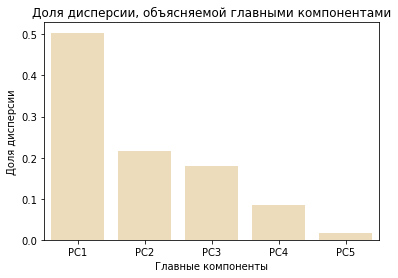

In [74]:
d = pd.DataFrame({'var':pca.explained_variance_ratio_, 'PC':['PC1', 'PC2', 'PC3','PC4','PC5']})
graph = sns.barplot(x = 'PC', y = 'var', data = d, color = 'wheat')
graph.set_title('Доля дисперсии, объясняемой главными компонентами')
graph.set_ylabel('Доля дисперсии')
graph.set_xlabel('Главные компоненты')

In [104]:
# Оценим регрессию price_sq на главные компоненты
regr = smf.ols('price_sq ~ PC1 + PC2 + PC3 + PC4 + PC5 + walk', data=principaldata).fit()
regr.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               price_sq   R-squared:                       0.338
Model:                            OLS   Adj. R-squared:                  0.336
Method:                 Least Squares   F-statistic:                     173.2
Date:                Sun, 20 Nov 2022   Prob (F-statistic):          3.12e-178
Time:                        18:40:57   Log-Likelihood:                -633.77
No. Observations:                2040   AIC:                             1282.
Df Residuals:                    2033   BIC:                             1321.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.6220      0.013    122.630      0.000       1.596       1.648
PC1            0.0975      0.005     21.118      0.000       0.088       0.107
PC2           -0.1322      0.007    -18.574      0.000      -0.146      -0.118
PC3            0.0597      0.008      7.688      0.000       0.044       0.075
PC4            0.0149      0.011      1.318      0.188      -0.007       0.037
PC5           -0.1173      0.026     -4.592      0.000      -0.167      -0.067
walk           0.1396      0.016      8.692      0.000       0.108       0.171
==============================================================================
Omnibus:                      833.914   Durbin-Watson:                   2.011
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             7507.026
Skew:                           1.678   Prob(JB):                         0.00
Kurtosis:                      11.778   Cond. No.                         5.55
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""